# Coronal Loop Hydrodynamics
Run the hydrodynamic simulations for each loop in the active region and compute the thermodynamic quantities as a function of time and space.

In [1]:
import os
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces import EbtelInterface, UniformHeating

%matplotlib inline

Restore from the base field.

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

Now setup the heating model. For the loop simulations, we'll use a single pulse of duration 200 s at $t=0$ s with total energy of

$$
E_s = \frac{(\epsilon B_s)^2}{8\pi}
$$

where $B_s$ is the average field strength along a strand $s$.

In [3]:
heating_options = {
    'duration':200,
    'average_waiting_time':8800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.3
}
heating_model = UniformHeating(heating_options)

Configure the simulation runs.

In [4]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [5]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/hydro_results/')

In [6]:
field.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

Run each of the loop simulations

In [7]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [8]:
pool = multiprocessing.Pool()

In [9]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [10]:
pool.close()

And then load the data from the simulations back in.

In [11]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

Take a look at the hydrodynamic results.

Text(0.5,0,'$t$ [s]')

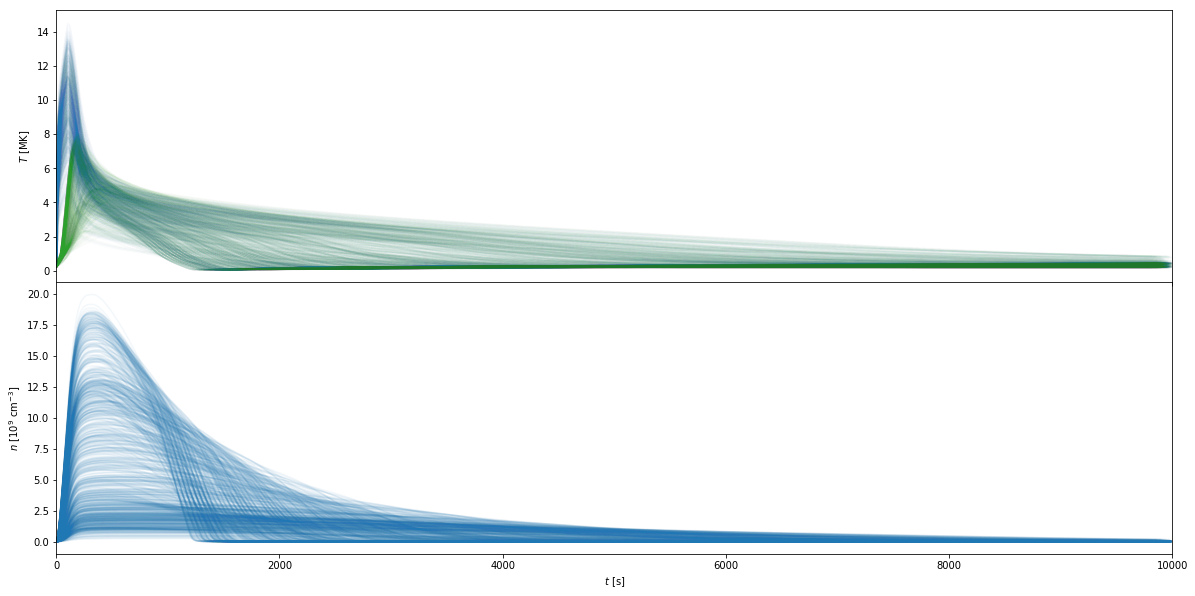

In [12]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.01)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.01)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Finally, save the field.

In [13]:
field.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/field_checkpoint')